# Clasificarea raselor de câini

# Introducere

## Scopul proiectului
Acest proiect explorează utilizarea tehnologiilor de viziune artificială pentru a realiza o 
clasificare precisă și automată a raselor de câini. Scopul fundamental al acestui proiect de 
clasificare a raselor de câini este de a dezvolta un sistem de învățare automată bazat pe 
tehnologii de viziune artificială care să poată identifica și să clasifice cu acuratețe trei rase de câini 
specifice: Beagle, Bracco Italiano și Husky Siberian, folosind imagini.


## Task
În cadrul acestui proiect, obiectivul principal este de a antrena mai multe modele de viziune artificială 
care să poată clasifica cu acuratețe rasele de câini menționate mai sus, folosind imaginile 
furnizate. Acest lucru presupune colectarea unui set de date relevant, antrenarea modelului și 
evaluarea performanței acestuia. Procesul implică adunarea și etichetarea imaginilor pentru setul 
de date, antrenarea modelelor, precum și generarea de 
grafice pentru a evidenția acuratețea modelelor.


## Context
Există peste 340 de rase de câini recunoscute oficial la nivel mondial. Această diversitate a 
raselor face clasificarea și identificarea acestora o sarcină complexă. Cu ajutorul algoritmilor și 
tehnologiilor avansate de viziune artificială, acest proiect se încadrează în eforturile de a 
automatiza procesul de identificare și clasificare a raselor de câini. Într-o lume în care informațiile 
vizuale joacă un rol tot mai important, această soluție poate fi utilă în diferite domenii, inclusiv în 
aplicații mobile sau web, precum și în cercetarea științifică legată de câini și genetica acestora.

## Setul de date

### Dimensiune
Dimensiunea setului de date este relevantă pentru a asigura o acuratețe semnificativă a modelului. Au fost colectate 120 de imagini 
pentru fiecare rasa de caine din cele 3 alese. 

### Anotări
Imaginile din setul de date vor fi etichetate corespunzător, indicând rasa specifică a 
câinelui din fiecare imagine, pentru a permite modelului să învețe și să efectueze clasificarea 
corectă.
Etichetele cu care voi lucra sunt: beagleXXX, huskeyXXX, braccoXXX (XXX va fi inlocuit cu numarul imaginii, iar numerotarea incepe de la 000 pana la 120).

In [1]:
#!jupyter nbconvert --to script "training_eval.ipynb"

In [103]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torch import nn, optim
from torchvision.models import alexnet, AlexNet_Weights
import torch.nn.functional as F
import matplotlib.pyplot as plt

#pentru preprocesarea setului de date
from PIL import Image
from torchvision import transforms
from torch.utils.data import ConcatDataset, DataLoader, random_split

from single_image_processing import process_image

## Preprocesarea setului de date
Acest bloc de cod se ocupă de pregătirea datelor pentru antrenarea unui model de rețea neuronală pentru clasificarea imaginilor de câini.
Setul de date este împărțit în setul de antrenare (70%), setul de validare (10%) și setul de testare (20%).

In [89]:
dog_dataset = "C:/Users/Emma/Dogs"
batch_size = 16 # cate imagini vor fi incarcate simultan in fiecare iteratie a antrenamentului
num_classes = 3

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(root=dog_dataset, transform=transform)

In [90]:
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
    
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

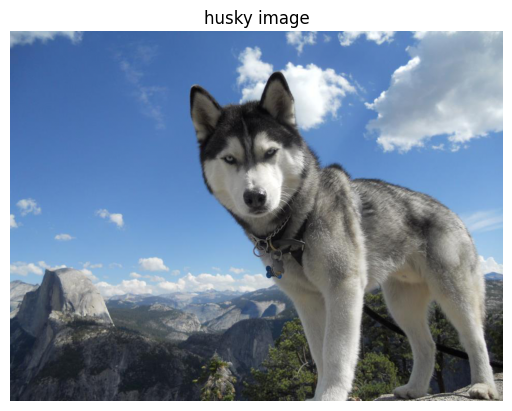

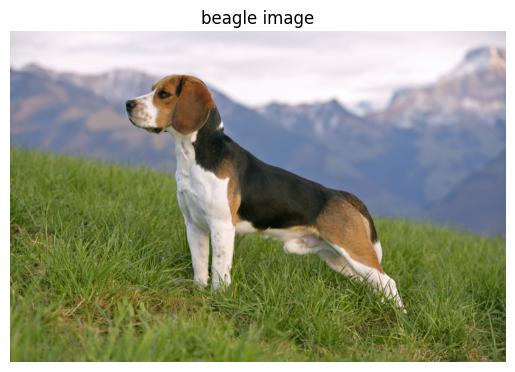

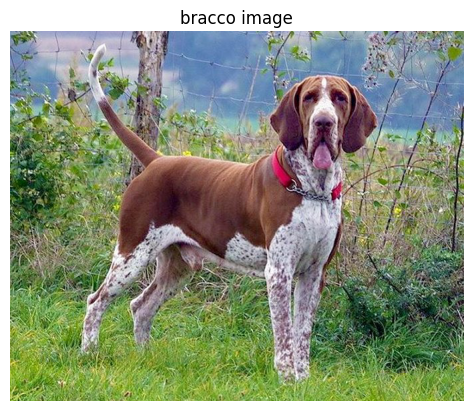

In [98]:
husky = "C:/Users/Emma/Dogs/Husky/husky001.jpg";
beagle = "C:/Users/Emma/Dogs/Beagle/beagle001.jpg";
bracco = "C:/Users/Emma/Dogs/Bracco/bracco001.jpg";

dogs = [husky, beagle, bracco];
categories = ["Husky", "Beagle", "Bracco"];

for category, image_path in zip(categories, dogs):
    
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    plt.imshow(image_np)
    plt.title(f"{category} image")
    plt.axis('off')
    plt.show()

## Functii generale

### Functia de antrenare a modelelor

In [104]:
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs):
    train_acc_history = []
    val_acc_history = []
    test_acc_history = []
    train_loss_history = []
    val_loss_history = []
    test_loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        model.train()
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)

        # Validation loop
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

            val_loss = running_loss / len(val_loader)
            val_acc = correct_val / total_val
            val_acc_history.append(val_acc)
            val_loss_history.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        


    return train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history


### Functia de evaluare a modelelor

In [105]:
def evaluate_model(model, dataloader):
    
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return accuracy


### Functia de afisare a graficelor

In [106]:
def show_plots(train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history):
    # Plot training, validation accuracy
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    # Plot training, validation loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

# VGG16
 Arhitectura VGG (Visual Geometry Group) este cunoscută pentru simplitatea sa și este compusă din straturi de convoluție cu filtre mici de 3x3. VGG11 sau VGG16 sunt variante ale acestei arhitecturi și pot fi utilizate pentru clasificarea imaginilor pe seturi de date mici. 
- Am creat modelul folosind arhitectura pre-antrenată VGG16 și weight-urile implicite pre-antrenate pe setul de date ImageNet. 
- Am înlocuit ultimul strat al clasificatorului (linia fully connected) cu un nou strat, adaptat pentru numărul specific de clase (3).
- Am definit funcția de pierdere ca CrossEntropyLoss, care este adecvată pentru problemele de clasificare.
- Am creat un optimizator Stochastic Gradient Descent (SGD) pentru a ajusta ponderile modelului în timpul antrenamentului.

In [99]:
model1 = models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

model1.classifier[6] = nn.Linear(model1.classifier[6].in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)

In [100]:
train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history = train_model(
    model1, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=4
)

Epoch 1/4: Train Acc: 0.8651, Val Acc: 0.8333, Train Loss: 0.3664, Val Loss: 0.3432
Epoch 2/4: Train Acc: 0.9683, Val Acc: 1.0000, Train Loss: 0.1455, Val Loss: 0.0513
Epoch 3/4: Train Acc: 1.0000, Val Acc: 1.0000, Train Loss: 0.0028, Val Loss: 0.0219
Epoch 4/4: Train Acc: 1.0000, Val Acc: 1.0000, Train Loss: 0.0014, Val Loss: 0.0164


## Acuratetea si pierderea de a lungul epocilor

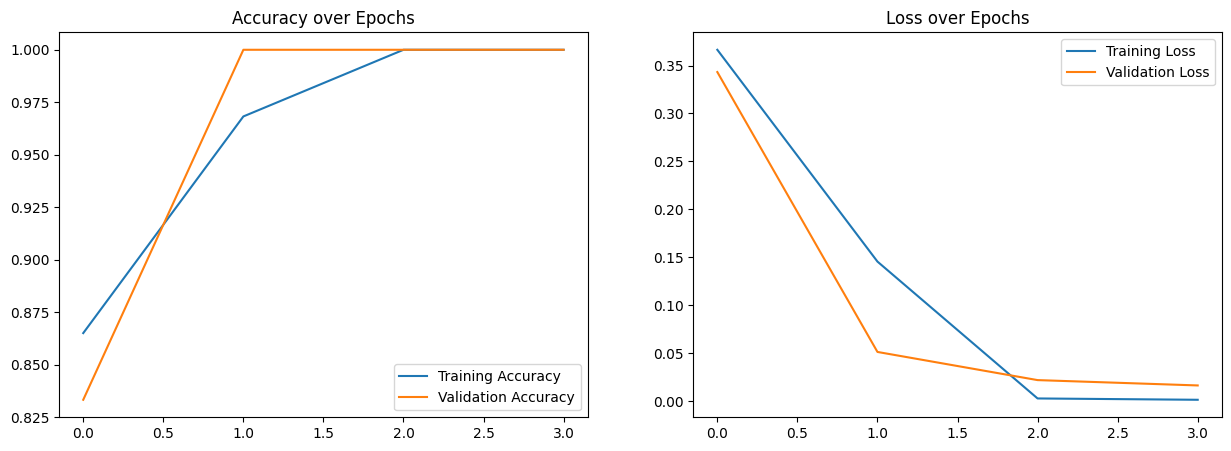

In [101]:
show_plots(train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history)

Graficul arată o îmbunătățire rapidă a acurateței de antrenare pe măsură ce progresează epocile, ceea ce sugerează că modelul învață eficient din datele de antrenament. Acuratețea validării și a testului începe cu o valoare mică, dar crește rapid, indicând o bună generalizare. Până la ultima epocă, acuratețea testului atinge 100%, ceea ce ar putea sugera overfitting pe setul de test sau că dimensiunea acestuia este foarte mică. Pierderile pentru toate seturile de date scad, cu o scădere abruptă a pierderii de antrenament și o tendință similară, dar cu oarecare variabilitate, pentru pierderile de validare și test. În general, modelul pare să se comporte bine pe sarcina dată, deși scorul perfect la test necesită o inspecție mai atentă pentru posibila scurgere de date sau overfitting.

In [102]:
evaluate_model(model1, test_loader)

Test Accuracy: 98.63%


98.63013698630137

In [133]:
idx_to_class = {0: 'Beagle', 1: 'Bracco', 2: 'Husky'}

image_path = 'C:/Users/Emma/codita.jpeg'
image_path2 = 'C:/Users/Emma/husk3.jpg'
result = process_image(image_path, model1, idx_to_class=idx_to_class)
result2 = process_image(image_path2, model1, idx_to_class=idx_to_class)
print(result)
print(result2)

{'image_path': 'C:/Users/Emma/codita.jpeg', 'predicted_class': 'Beagle', 'probability': 0.9999136924743652}
{'image_path': 'C:/Users/Emma/husk3.jpg', 'predicted_class': 'Husky', 'probability': 1.0}


# AlexNet model


AlexNet este o rețea neurală convoluțională pionieră care a introdus utilizarea funcțiilor de activare ReLU, antrenamentul pe GPU, tehnici de dropout și augmentare a datelor pentru a îmbunătăți performanța în clasificarea imaginilor.

In [8]:
model2 = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1) 
model2.classifier[6] = torch.nn.Linear(model2.classifier[6].in_features, 3)

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.0001, momentum=0.9)

In [10]:
train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history = train_model(
    model2, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5: Train Acc: 0.8492, Val Acc: 0.9444, Train Loss: 0.3663, Val Loss: 0.1666
Epoch 2/5: Train Acc: 0.9841, Val Acc: 0.9444, Train Loss: 0.0561, Val Loss: 0.1100
Epoch 3/5: Train Acc: 0.9960, Val Acc: 1.0000, Train Loss: 0.0288, Val Loss: 0.0874
Epoch 4/5: Train Acc: 1.0000, Val Acc: 1.0000, Train Loss: 0.0254, Val Loss: 0.0713
Epoch 5/5: Train Acc: 1.0000, Val Acc: 1.0000, Train Loss: 0.0180, Val Loss: 0.0602


## Acuratetea si pierderea de a lungul epocilor

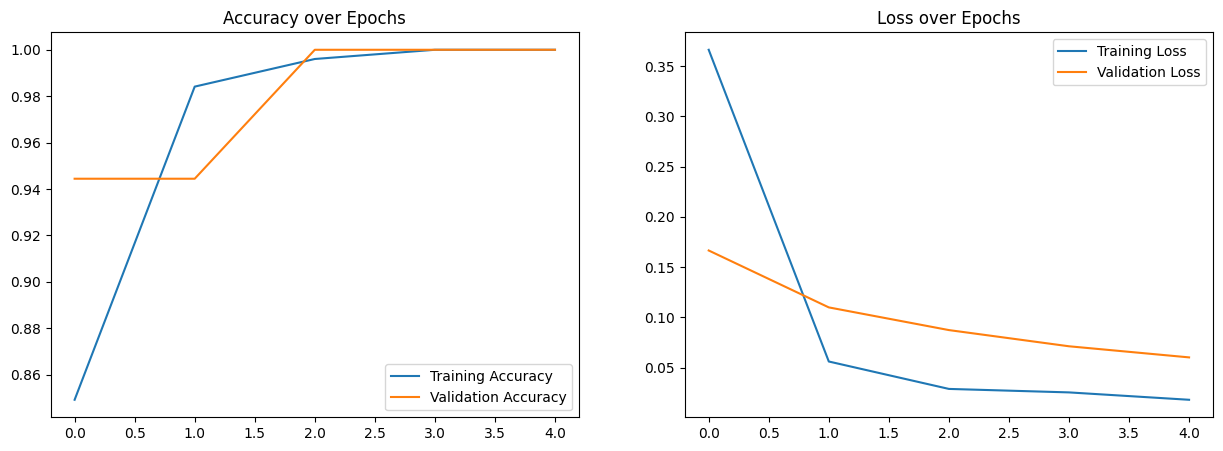

In [11]:
show_plots(train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history)

Graficul indică o îmbunătățire rapidă și constantă a acurateței de antrenare și se stabilizează la un nivel înalt, ceea ce sugerează că modelul învață eficient. Acuratețea validării și a testului se aliniază și ele la niveluri înalte, sugerând o bună generalizare a modelului. Pierderea în timpul antrenamentului scade rapid, indicând o convergență bună, iar pierderea de validare și test urmează o tendință descendentă, ajungând la un nivel stabil. Aceasta sugerează că modelul nu doar că învață bine, dar se generalizează și eficient pe date nevăzute.

In [12]:
evaluate_model(model2, test_loader)

Test Accuracy: 98.63%


98.63013698630137

# SqueezeNet
SqueezeNet se evidențiază printr-o abordare inovatoare, reducând numărul de parametri în comparație cu alte arhitecturi, fără a compromite performanța. O caracteristică distinctivă a SqueezeNet este utilizarea blocurilor de "squeeze" și "expand", care optimizează procesul de extragere a caracteristicilor și reduce consumul de resurse. Am înlocuit stratul fully connected cu un strat de convoluție (nn.Conv2d) care se potrivește cu numărul de clase din setul meu de date. Această modificare este esențială pentru a face modelul să fie coerent cu specificul sarcinii de clasificare a imaginilor în contextul proiectului meu.

In [14]:
model3 = torchvision.models.squeezenet1_0(weights=torchvision.models.SqueezeNet1_0_Weights.DEFAULT)
model3.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.0001, momentum=0.9)

In [15]:
train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history = train_model(
    model3, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=7
)

Epoch 1/7: Train Acc: 0.6270, Val Acc: 0.9167, Train Loss: 0.8564, Val Loss: 0.2933
Epoch 2/7: Train Acc: 0.9246, Val Acc: 0.9722, Train Loss: 0.2123, Val Loss: 0.1131
Epoch 3/7: Train Acc: 0.9802, Val Acc: 0.9722, Train Loss: 0.0893, Val Loss: 0.0763
Epoch 4/7: Train Acc: 0.9841, Val Acc: 1.0000, Train Loss: 0.0581, Val Loss: 0.0577
Epoch 5/7: Train Acc: 0.9960, Val Acc: 1.0000, Train Loss: 0.0267, Val Loss: 0.0582
Epoch 6/7: Train Acc: 0.9960, Val Acc: 1.0000, Train Loss: 0.0171, Val Loss: 0.0498
Epoch 7/7: Train Acc: 1.0000, Val Acc: 1.0000, Train Loss: 0.0138, Val Loss: 0.0349


## Acuratetea si pierderea de a lungul epocilor
Graficul arată o îmbunătățire constantă a acurateței de antrenare, validare și testare pe măsură ce progresează epocile. Acuratețea de antrenare începe mai jos, dar ajunge la un nivel apropiat de acuratețea de validare și testare, ceea ce este pozitiv. Pierderile scad în mod consistent pentru toate cele trei seturi de date, indicând o bună convergență a modelului. Este un semn bun că acuratețea de validare și testare se îmbunătățesc în tandem, sugerând că modelul nu suferă de supraajustare semnificativă și că generalizează bine la datele nevăzute.

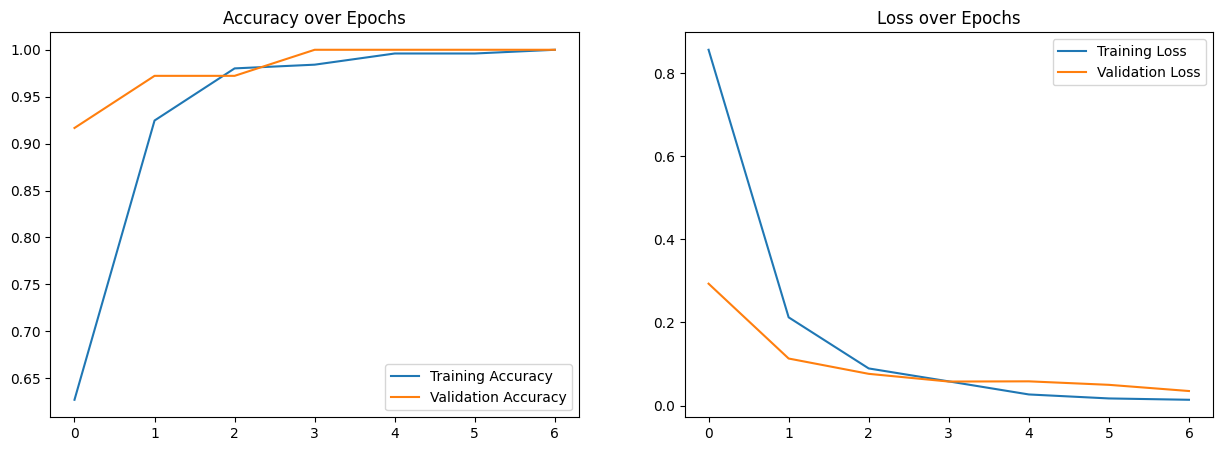

In [16]:
show_plots(train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history)

In [18]:
 evaluate_model(model3, test_loader)

Test Accuracy: 98.63%


98.63013698630137

# ResNet

Punctul central al ResNet este utilizarea "conexiunilor reziduale" sau "scurtăturilor" care permit semnalelor să ocolească unul sau mai multe straturi. Practic, în loc să învețe funcții directe, straturile în ResNet învață diferențele (reziduurile) dintre intrări și ieșiri. Această abordare ajută la combaterea problemei dispariției sau exploziei gradientului, care devine tot mai proeminentă pe măsură ce rețelele devin mai profunde.

In [18]:
model4 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
num_classes = 3 
model4.fc = nn.Linear(model4.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model4.parameters(), lr=0.0001, momentum=0.9)

train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history = train_model(
    model4, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10
)

Epoch 1/10: Train Acc: 0.3611, Val Acc: 0.6111, Train Loss: 1.2736, Val Loss: 0.9897
Epoch 2/10: Train Acc: 0.4127, Val Acc: 0.6667, Train Loss: 1.1904, Val Loss: 0.9159
Epoch 3/10: Train Acc: 0.4683, Val Acc: 0.7222, Train Loss: 1.0773, Val Loss: 0.8422
Epoch 4/10: Train Acc: 0.5357, Val Acc: 0.8056, Train Loss: 0.9686, Val Loss: 0.7744
Epoch 5/10: Train Acc: 0.7222, Val Acc: 0.8889, Train Loss: 0.8669, Val Loss: 0.7147
Epoch 6/10: Train Acc: 0.7937, Val Acc: 0.9444, Train Loss: 0.7880, Val Loss: 0.6550
Epoch 7/10: Train Acc: 0.8611, Val Acc: 1.0000, Train Loss: 0.7297, Val Loss: 0.5967
Epoch 8/10: Train Acc: 0.8849, Val Acc: 1.0000, Train Loss: 0.6620, Val Loss: 0.5452
Epoch 9/10: Train Acc: 0.9246, Val Acc: 1.0000, Train Loss: 0.6057, Val Loss: 0.4980
Epoch 10/10: Train Acc: 0.9444, Val Acc: 1.0000, Train Loss: 0.5536, Val Loss: 0.4548


## Acuratetea si pierderea de a lungul epocilor

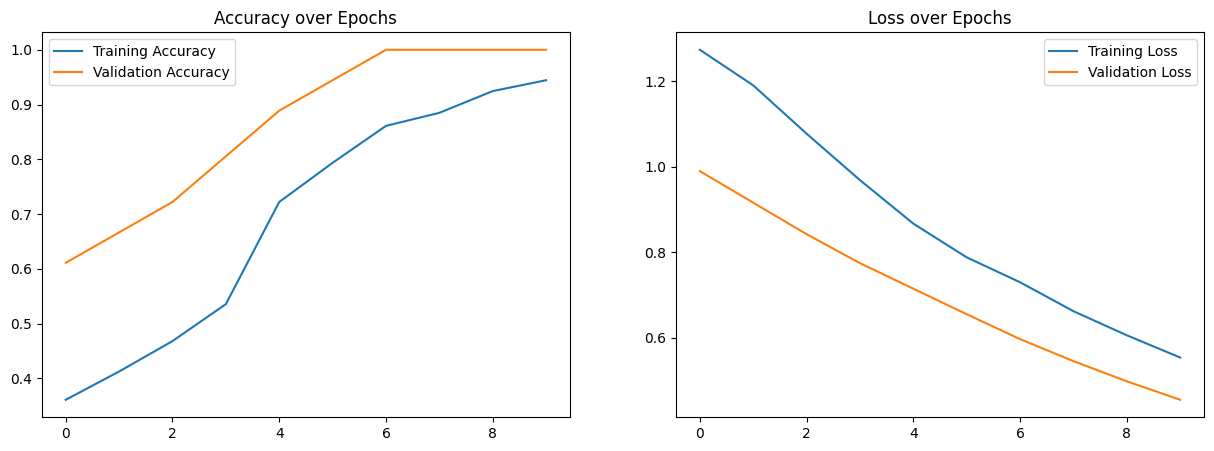

In [19]:
show_plots(train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history)

Acest grafic arată o tendință pozitivă a acurateței și a pierderilor pe parcursul a patru epoci de antrenament. Acuratețea de antrenament crește rapid și se stabilizează la un nivel înalt împreună cu acuratețea de validare și testare, ceea ce indică o bună capacitate de generalizare a modelului. Pe graficul pierderilor, toate cele trei seturi de date arată o scădere constantă a pierderilor, cu pierderea de antrenament care scade mai repede și pierderea de validare și test care converge spre o valoare similară. Aceasta sugerează că modelul se comportă consistent pe măsură ce învață din date.

In [20]:
 evaluate_model(model4, test_loader)

Test Accuracy: 87.67%


87.67123287671232

In [134]:
result = process_image(image_path, model4, idx_to_class=idx_to_class)
result2 = process_image(image_path2, model4, idx_to_class=idx_to_class)
print(result)
print(result2)

{'image_path': 'C:/Users/Emma/codita.jpeg', 'predicted_class': 'Beagle', 'probability': 0.5272852778434753}
{'image_path': 'C:/Users/Emma/husk3.jpg', 'predicted_class': 'Husky', 'probability': 0.8150424361228943}


# DenseNet

In [26]:
model5 = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)
model5.classifier = nn.Linear(model5.classifier.in_features, num_classes)

In [27]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model5.parameters(), lr=0.0001, momentum=0.9)

train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history = train_model(
    model5, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=9
)

Epoch 1/9: Train Acc: 0.2659, Val Acc: 0.4167, Train Loss: 1.1348, Val Loss: 1.1015
Epoch 2/9: Train Acc: 0.3135, Val Acc: 0.4722, Train Loss: 1.0914, Val Loss: 1.0531
Epoch 3/9: Train Acc: 0.4484, Val Acc: 0.5833, Train Loss: 1.0229, Val Loss: 0.9935
Epoch 4/9: Train Acc: 0.5476, Val Acc: 0.6389, Train Loss: 0.9562, Val Loss: 0.9295
Epoch 5/9: Train Acc: 0.7381, Val Acc: 0.7500, Train Loss: 0.8730, Val Loss: 0.8596
Epoch 6/9: Train Acc: 0.8452, Val Acc: 0.8056, Train Loss: 0.8001, Val Loss: 0.7865
Epoch 7/9: Train Acc: 0.9048, Val Acc: 0.8611, Train Loss: 0.7276, Val Loss: 0.7190
Epoch 8/9: Train Acc: 0.9484, Val Acc: 0.9167, Train Loss: 0.6608, Val Loss: 0.6581
Epoch 9/9: Train Acc: 0.9603, Val Acc: 0.9167, Train Loss: 0.6151, Val Loss: 0.6027


## Acuratetea si pierderea de a lungul epocilor

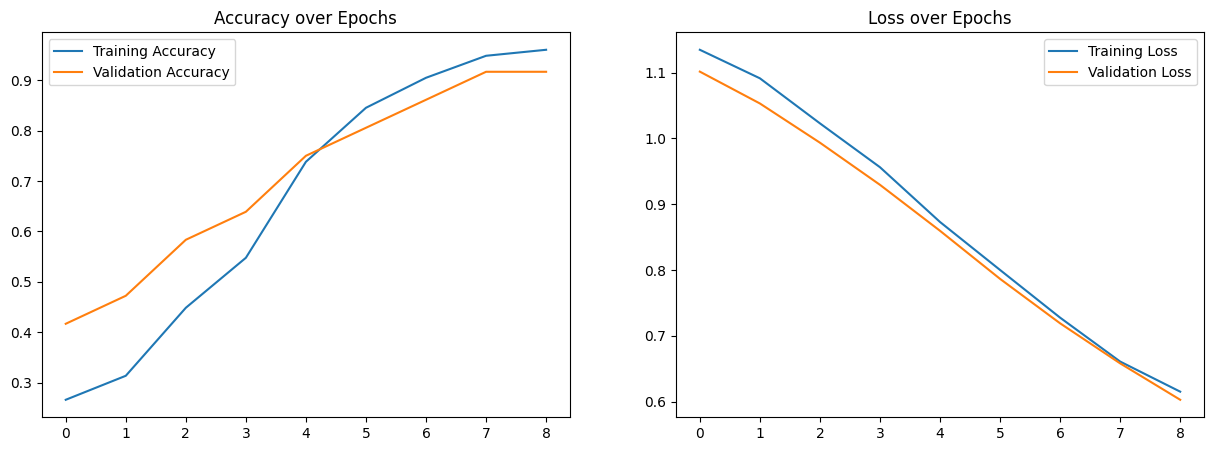

In [28]:
show_plots(train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history)

Ceea ce este pozitiv în aceste grafice este faptul că liniile pentru acuratețea și pierderea de validare urmăresc îndeaproape liniile pentru acuratețea și pierderea de antrenare, ceea ce sugerează că modelul nu suferă de overfitting semnificativ. De asemenea, faptul că liniile de loss converg indică faptul că modelul este relativ stabil și ar putea beneficia de mai multe epoci de antrenare pentru a îmbunătăți performanța, dat fiind că nu există semne clare de overfitting.

In [29]:
 evaluate_model(model5, test_loader)

Test Accuracy: 87.67%


87.67123287671232

In [135]:
result = process_image(image_path, model5, idx_to_class=idx_to_class)
result2 = process_image(image_path2, model5, idx_to_class=idx_to_class)
print(result)
print(result2)

{'image_path': 'C:/Users/Emma/codita.jpeg', 'predicted_class': 'Beagle', 'probability': 0.4981843829154968}
{'image_path': 'C:/Users/Emma/husk3.jpg', 'predicted_class': 'Husky', 'probability': 0.6669237613677979}


## ShuffleNet


### Antrenare de la zero

Epoch 1/30: Train Acc: 0.4405, Val Acc: 0.4167, Train Loss: 1.1761, Val Loss: 1.0988
Epoch 2/30: Train Acc: 0.4603, Val Acc: 0.5000, Train Loss: 1.0646, Val Loss: 1.1685
Epoch 3/30: Train Acc: 0.5833, Val Acc: 0.5000, Train Loss: 0.9283, Val Loss: 1.4001
Epoch 4/30: Train Acc: 0.6151, Val Acc: 0.5278, Train Loss: 0.9053, Val Loss: 1.4283
Epoch 5/30: Train Acc: 0.5952, Val Acc: 0.5000, Train Loss: 0.9080, Val Loss: 1.3437
Epoch 6/30: Train Acc: 0.6944, Val Acc: 0.5278, Train Loss: 0.7344, Val Loss: 1.4848
Epoch 7/30: Train Acc: 0.7222, Val Acc: 0.5000, Train Loss: 0.6803, Val Loss: 1.3879
Epoch 8/30: Train Acc: 0.7460, Val Acc: 0.5833, Train Loss: 0.6028, Val Loss: 1.5396
Epoch 9/30: Train Acc: 0.7817, Val Acc: 0.3611, Train Loss: 0.5773, Val Loss: 1.5899
Epoch 10/30: Train Acc: 0.8254, Val Acc: 0.5278, Train Loss: 0.4850, Val Loss: 1.4899
Epoch 11/30: Train Acc: 0.7857, Val Acc: 0.4444, Train Loss: 0.5390, Val Loss: 1.6558
Epoch 12/30: Train Acc: 0.8968, Val Acc: 0.4722, Train Loss: 0.

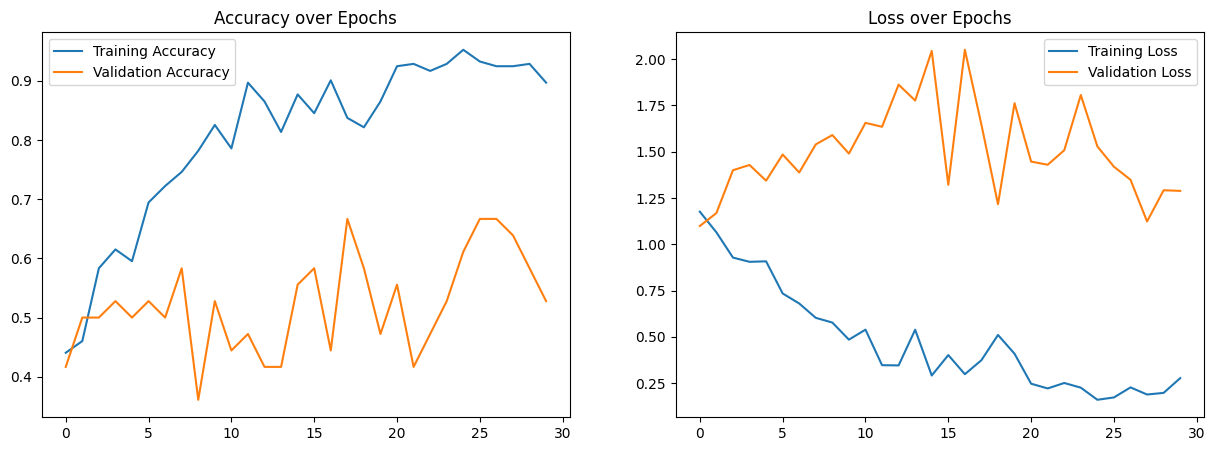

In [109]:
#scratch
model_scratch = models.shufflenet_v2_x1_0(pretrained=False)
model_scratch.fc = nn.Linear(model_scratch.fc.in_features, num_classes)

optimizer_scratch = torch.optim.Adam(model_scratch.parameters(), lr=0.001)
criterion_scratch = nn.CrossEntropyLoss()

train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history = train_model(
    model_scratch, train_loader, val_loader, test_loader, criterion_scratch, optimizer_scratch, num_epochs=30
)

show_plots(train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history)

Acuratețea de antrenare crește în mod constant până la aproximativ 0.9, ceea ce indică o învățare eficientă pe setul de date de invatare. Acuratețea de validare este mult mai volatilă și are un trend general ascendent până la aproximativ epoca 10, după care fluctuează semnificativ și înregistrează o scădere notabilă după epoca 25, indicând posibil un început de overfitting sau o nevoie de reglare a hiperparametrilor. Pierderea pe antrenare scade în mod constant pe parcursul celor 30 de epoci, ceea ce este tipic pentru procesul de antrenament. Pierderea de validare devine foarte instabilă și crește semnificativ spre sfârșitul perioadei de antrenament, ceea ce sugerează că modelul nu generalizează bine pe datele noi și că ar putea fi necesară ajustarea modelului sau a procesului de antrenament pentru a îmbunătăți performanța pe setul de validare.

In [110]:
 evaluate_model(model_scratch, test_loader)

Test Accuracy: 60.27%


60.273972602739725

In [136]:
result = process_image(image_path, model_scratch, idx_to_class=idx_to_class)
result2 = process_image(image_path2, model_scratch, idx_to_class=idx_to_class)
print(result)
print(result2)

{'image_path': 'C:/Users/Emma/codita.jpeg', 'predicted_class': 'Beagle', 'probability': 0.9449915885925293}
{'image_path': 'C:/Users/Emma/husk3.jpg', 'predicted_class': 'Husky', 'probability': 0.977124035358429}


### Extragere caracteristicilor

Epoch 1/70: Train Acc: 0.3254, Val Acc: 0.4167, Train Loss: 1.0979, Val Loss: 1.0914
Epoch 2/70: Train Acc: 0.5040, Val Acc: 0.6667, Train Loss: 1.0911, Val Loss: 1.0866
Epoch 3/70: Train Acc: 0.6508, Val Acc: 0.6944, Train Loss: 1.0834, Val Loss: 1.0811
Epoch 4/70: Train Acc: 0.6825, Val Acc: 0.6389, Train Loss: 1.0767, Val Loss: 1.0744
Epoch 5/70: Train Acc: 0.7103, Val Acc: 0.6667, Train Loss: 1.0695, Val Loss: 1.0688
Epoch 6/70: Train Acc: 0.6944, Val Acc: 0.5833, Train Loss: 1.0645, Val Loss: 1.0637
Epoch 7/70: Train Acc: 0.7183, Val Acc: 0.6111, Train Loss: 1.0563, Val Loss: 1.0574
Epoch 8/70: Train Acc: 0.7262, Val Acc: 0.6111, Train Loss: 1.0513, Val Loss: 1.0504
Epoch 9/70: Train Acc: 0.7183, Val Acc: 0.6111, Train Loss: 1.0444, Val Loss: 1.0453
Epoch 10/70: Train Acc: 0.7262, Val Acc: 0.5833, Train Loss: 1.0383, Val Loss: 1.0416
Epoch 11/70: Train Acc: 0.7421, Val Acc: 0.5833, Train Loss: 1.0322, Val Loss: 1.0358
Epoch 12/70: Train Acc: 0.7103, Val Acc: 0.7222, Train Loss: 1.

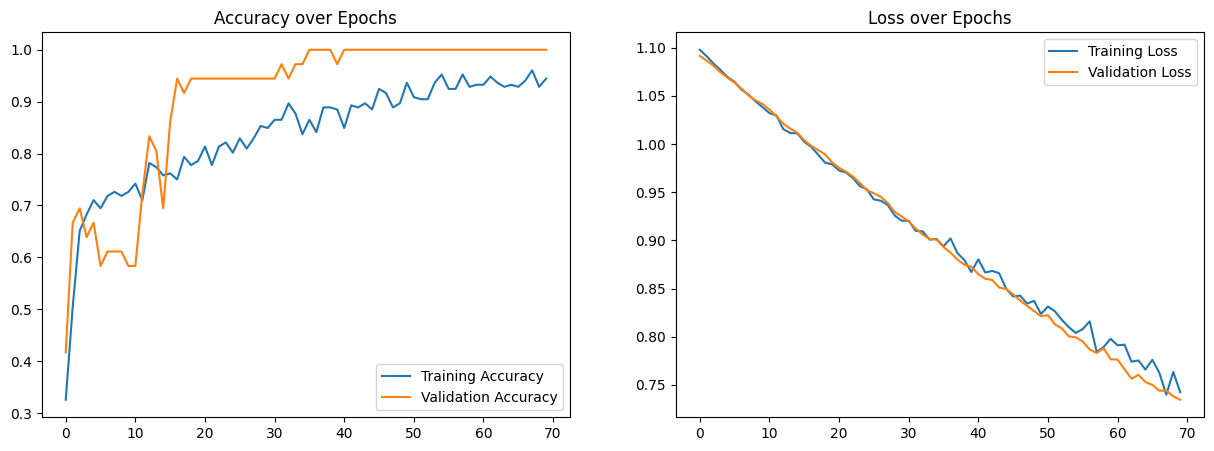

In [24]:
#feature extraction
model_feature_extraction = models.shufflenet_v2_x1_0(pretrained=True)
for param in model_feature_extraction.parameters():
    param.requires_grad = False
model_feature_extraction.fc = nn.Linear(model_feature_extraction.fc.in_features, num_classes)

optimizer_feature_extraction = torch.optim.Adam(model_feature_extraction.parameters(), lr=0.0001)
criterion_feature_extraction = nn.CrossEntropyLoss()

train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history = train_model(
    model_feature_extraction, train_loader, val_loader, test_loader, criterion_feature_extraction, optimizer_feature_extraction, num_epochs=70
)

show_plots(train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history)

Graficul indică un comportament normal al procesului de antrenament, cu modelul care învață eficient și generalizează bine performanța de pe setul de antrenament la setul de validare, cu o disparitate mică între acuratețea și pierderea celor două seturi. Aceasta sugerează că modelul este bine reglat și nu pare să sufere de overfitting sau underfitting semnificativ..

In [25]:
 evaluate_model( model_feature_extraction, test_loader)

Test Accuracy: 95.89%


95.89041095890411

In [137]:
result = process_image(image_path, model_feature_extraction, idx_to_class=idx_to_class)
result2 = process_image(image_path2, model_feature_extraction, idx_to_class=idx_to_class)
print(result)
print(result2)

{'image_path': 'C:/Users/Emma/codita.jpeg', 'predicted_class': 'Husky', 'probability': 0.34857818484306335}
{'image_path': 'C:/Users/Emma/husk3.jpg', 'predicted_class': 'Husky', 'probability': 0.3527029752731323}


### Fine-tuning

Epoch 1/5: Train Acc: 0.5079, Val Acc: 0.9167, Train Loss: 1.0893, Val Loss: 1.0652
Epoch 2/5: Train Acc: 0.9048, Val Acc: 0.9444, Train Loss: 1.0546, Val Loss: 1.0220
Epoch 3/5: Train Acc: 0.9524, Val Acc: 0.9444, Train Loss: 1.0120, Val Loss: 0.9480
Epoch 4/5: Train Acc: 0.9921, Val Acc: 1.0000, Train Loss: 0.9419, Val Loss: 0.8480
Epoch 5/5: Train Acc: 0.9524, Val Acc: 1.0000, Train Loss: 0.8742, Val Loss: 0.7321


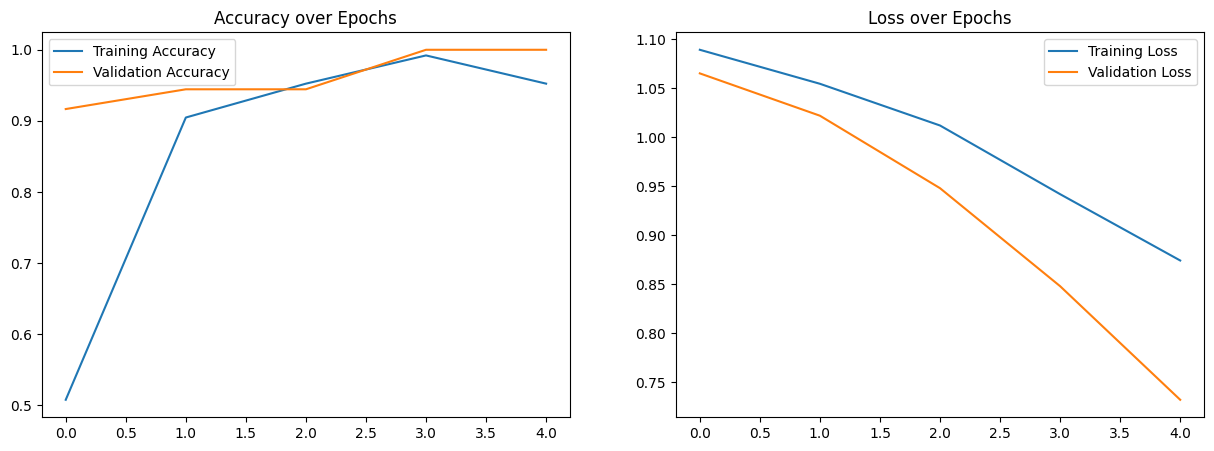

In [53]:
#fine-tuning
model_fine_tuning = models.shufflenet_v2_x1_0(pretrained=True)
model_fine_tuning.fc = nn.Linear(model_fine_tuning.fc.in_features, num_classes)

optimizer_fine_tuning = torch.optim.Adam(model_fine_tuning.parameters(), lr=0.0001)
criterion_fine_tuning = nn.CrossEntropyLoss()

train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history = train_model(
    model_fine_tuning, train_loader, val_loader, test_loader, criterion_fine_tuning, optimizer_fine_tuning, num_epochs=5
)

show_plots(train_acc_history, val_acc_history, test_acc_history, train_loss_history, val_loss_history, test_loss_history)

Deși există o discrepanță între acuratețea și pierderea de antrenare și validare, aceasta nu este semnificativă. Modelul arată semne de bună generalizare, deși ar putea fi încă loc de îmbunătățiri, poate prin finisarea hiperparametrilor sau prin continuarea antrenamentului pentru mai multe epoci. Graficul indică, de asemenea, că nu s-a ajuns la convergență completă, așa că antrenamentul suplimentar ar putea continua să îmbunătățească performanța modelului fără un risc imediat de overfitting

In [54]:
 evaluate_model(model_fine_tuning, test_loader)

Test Accuracy: 100.00%


100.0

In [138]:
result = process_image(image_path, model_fine_tuning, idx_to_class=idx_to_class)
result2 = process_image(image_path2, model_fine_tuning, idx_to_class=idx_to_class)
print(result)
print(result2)

{'image_path': 'C:/Users/Emma/codita.jpeg', 'predicted_class': 'Beagle', 'probability': 0.45540502667427063}
{'image_path': 'C:/Users/Emma/husk3.jpg', 'predicted_class': 'Husky', 'probability': 0.5622020959854126}


## Concluzie

În acest notebook, am explorat și comparat performanța a șase arhitecturi de rețea neurală convoluțională diferite - ResNet, DenseNet, AlexNet, ShuffleNet, SqueezeNet și VGG16 - în sarcina de clasificare a raselor de câini. Fiecare model a fost adaptat și antrenat pe un set de date cuprinzător de imagini de câini, urmărindu-se acuratețea și pierderea în timpul procesului de antrenament și de validare.

Rezultatele experimentelor arată diferențe notabile între modele în ceea ce privește acuratețea și pierderea, ilustrând importanța selecției arhitecturii în contextul unei sarcini specifice de clasificare. ResNet și DenseNet, cunoscute pentru capacitatea lor de a antrena rețele adânci fără a pierde eficiența în propagarea gradientului, au obținut scoruri de acuratețe decente, indicând o puternică capacitate de generalizare. Pe de altă parte, arhitecturi mai vechi și mai simple, cum ar fi AlexNet, au avut performanțe ceva mai ridicate.

În plus, modelele mai ușoare, precum ShuffleNet și SqueezeNet, au oferit un echilibru între eficiența calculului și performanța satisfăcătoare, ceea ce le-ar putea face candidați potriviti pentru aplicații în timp real sau pe dispozitive cu resurse limitate. 